#### Code to plot theta

In [13]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager


# plot of theta and theta_e anomaly time series
data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/'

# reading original variables
theta_e_list = [data_path+'theta_e_20200202.nc', data_path+'theta_e_20200203.nc']
theta_list = [data_path+'theta_20200202.nc', data_path+'theta_20200203.nc']

# read the two datasets together
theta_e_dataset = xr.open_mfdataset(theta_e_list)
theta_dataset = xr.open_mfdataset(theta_list)

theta_e = theta_e_dataset.product_no_noise.values
theta = theta_dataset.product_no_noise.values
theta_e_anomaly = theta_e_dataset.product_no_diurnal_cycle.values
theta_anomaly = theta_dataset.product_no_diurnal_cycle.values

# creating unique dataset of the variables 
# converting the list of dictionaries in a dictionary called variables to be saved in ncdf
dims             = ['time','height']
coords           = {'time':theta_e_dataset.time.values, 'height':theta_e_dataset['height'].values}
variables = {'theta':xr.DataArray(dims=dims, coords=coords, data=theta,
                             attrs={'long_name':'theta',
                                    'units':'K'}), 
            'theta_e':xr.DataArray(dims=dims, coords=coords, data=theta_e,
                             attrs={'long_name':'theta_e',
                                    'units':'K'}),
            'theta_anomaly':xr.DataArray(dims=dims, coords=coords, data=theta_anomaly,
                             attrs={'long_name':'theta_anomaly',
                                    'units':'K'}), 
            'theta_e_anomaly':xr.DataArray(dims=dims, coords=coords, data=theta_e_anomaly,
                             attrs={'long_name':'theta_e_anomaly',
                                    'units':'K'})}


global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'PI_NAME'          : 'Claudia Acquistapace',
                        'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : '',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : 'arthus data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                         'COMMENT'         : 'original data postprocessed by Diego Lange' }
theta_dataset    = xr.Dataset(data_vars = variables,
                        coords = coords,
                        attrs = global_attributes)




In [14]:
theta_dataset

<xarray.Dataset>
Dimensions:          (height: 57, time: 16617)
Coordinates:
  * time             (time) datetime64[ns] 2020-02-02T00:00:08 ... 2020-02-03...
  * height           (height) float64 225.0 275.0 325.0 ... 2.975e+03 3.025e+03
Data variables:
    theta            (time, height) float64 302.7 303.3 303.2 ... nan nan nan
    theta_e          (time, height) float64 345.4 346.2 346.5 ... nan nan nan
    theta_anomaly    (time, height) float64 0.3779 0.02024 -0.4396 ... nan nan
    theta_e_anomaly  (time, height) float64 -4.66 -5.094 -4.812 ... nan nan nan
Attributes:
    CREATED_BY:        Claudia Acquistapace
    CREATED_ON:        2022-02-13 11:52:26.801267
    FILL_VALUE:        NaN
    PI_NAME:           Claudia Acquistapace
    PI_AFFILIATION:    University of Cologne (UNI), Germany
    PI_ADDRESS:        Institute for geophysics and meteorology, Pohligstrass...
    PI_MAIL:           cacquist@meteo.uni-koeln.de
    DATA_DESCRIPTION:  
    DATA_DISCIPLINE:   Atmospheric Physics - Remote Sensing Lidar Profiler
    DATA_GROUP:        Experimental;Profile;Moving
    DATA_SOURCE:       arthus data
    DATA_PROCESSING:   https://github.com/ClauClouds/SST-impact/
    INSTRUMENT_MODEL:  arthus raman lidar system
    COMMENT:           original data postprocessed by Diego Lange

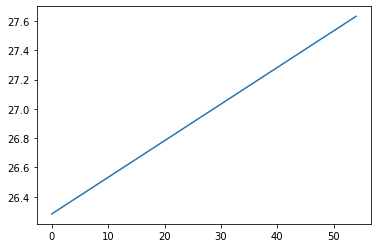

In [4]:

# read SST temperature
# reading tsg file ( data with 1 min resolution)
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"

tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)

# opening noise mask file to read cloud base
noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
noise_mask = xr.open_dataset(noise_mask_file)
noise_mask = noise_mask.sel(Time=slice(datetime(2020,2,2,0,0,0), datetime(2020,2,3,23,59,59)))

cloud_base = noise_mask.cloud_base_height.values


In [15]:
# interpolate SST on theta dataset
sst_interp = SST_DS.interp(time=theta_dataset.time.values)

In [17]:
# merge the datasets 
data_all = xr.merge([theta_dataset,sst_interp])

In [18]:
data_all

<xarray.Dataset>
Dimensions:          (height: 57, time: 16617)
Coordinates:
  * time             (time) datetime64[ns] 2020-02-02T00:00:08 ... 2020-02-03...
  * height           (height) float64 225.0 275.0 325.0 ... 2.975e+03 3.025e+03
Data variables:
    theta            (time, height) float64 302.7 303.3 303.2 ... nan nan nan
    theta_e          (time, height) float64 345.4 346.2 346.5 ... nan nan nan
    theta_anomaly    (time, height) float64 0.3779 0.02024 -0.4396 ... nan nan
    theta_e_anomaly  (time, height) float64 -4.66 -5.094 -4.812 ... nan nan nan
    SST              (time) float64 nan nan nan nan ... 26.97 26.98 26.98 26.98

In [20]:
# ccalculating 10th percentile for ship sst
perc_10th = np.nanpercentile(data_all.SST.values, 10.)
perc_90th = np.nanpercentile(data_all.SST.values, 90.)
print(perc_10th, perc_90th)

26.434473333443528 27.454200000274774


In [34]:
# selecting profiles for low and high percentiles
dataset_10 = data_all.sel(time=data_all.time.values[(data_all.SST.values < perc_10th)])
dataset_90 = data_all.sel(time=data_all.time.values[(data_all.SST.values > perc_90th)])

In [35]:
mean_profile_10 = dataset_10.mean(dim='time', skipna=True)
std_profile_10 = dataset_10.std(dim='time', skipna=True)
mean_profile_90 = dataset_90.mean(dim='time', skipna=True)
std_profile_90 = dataset_90.std(dim='time', skipna=True)

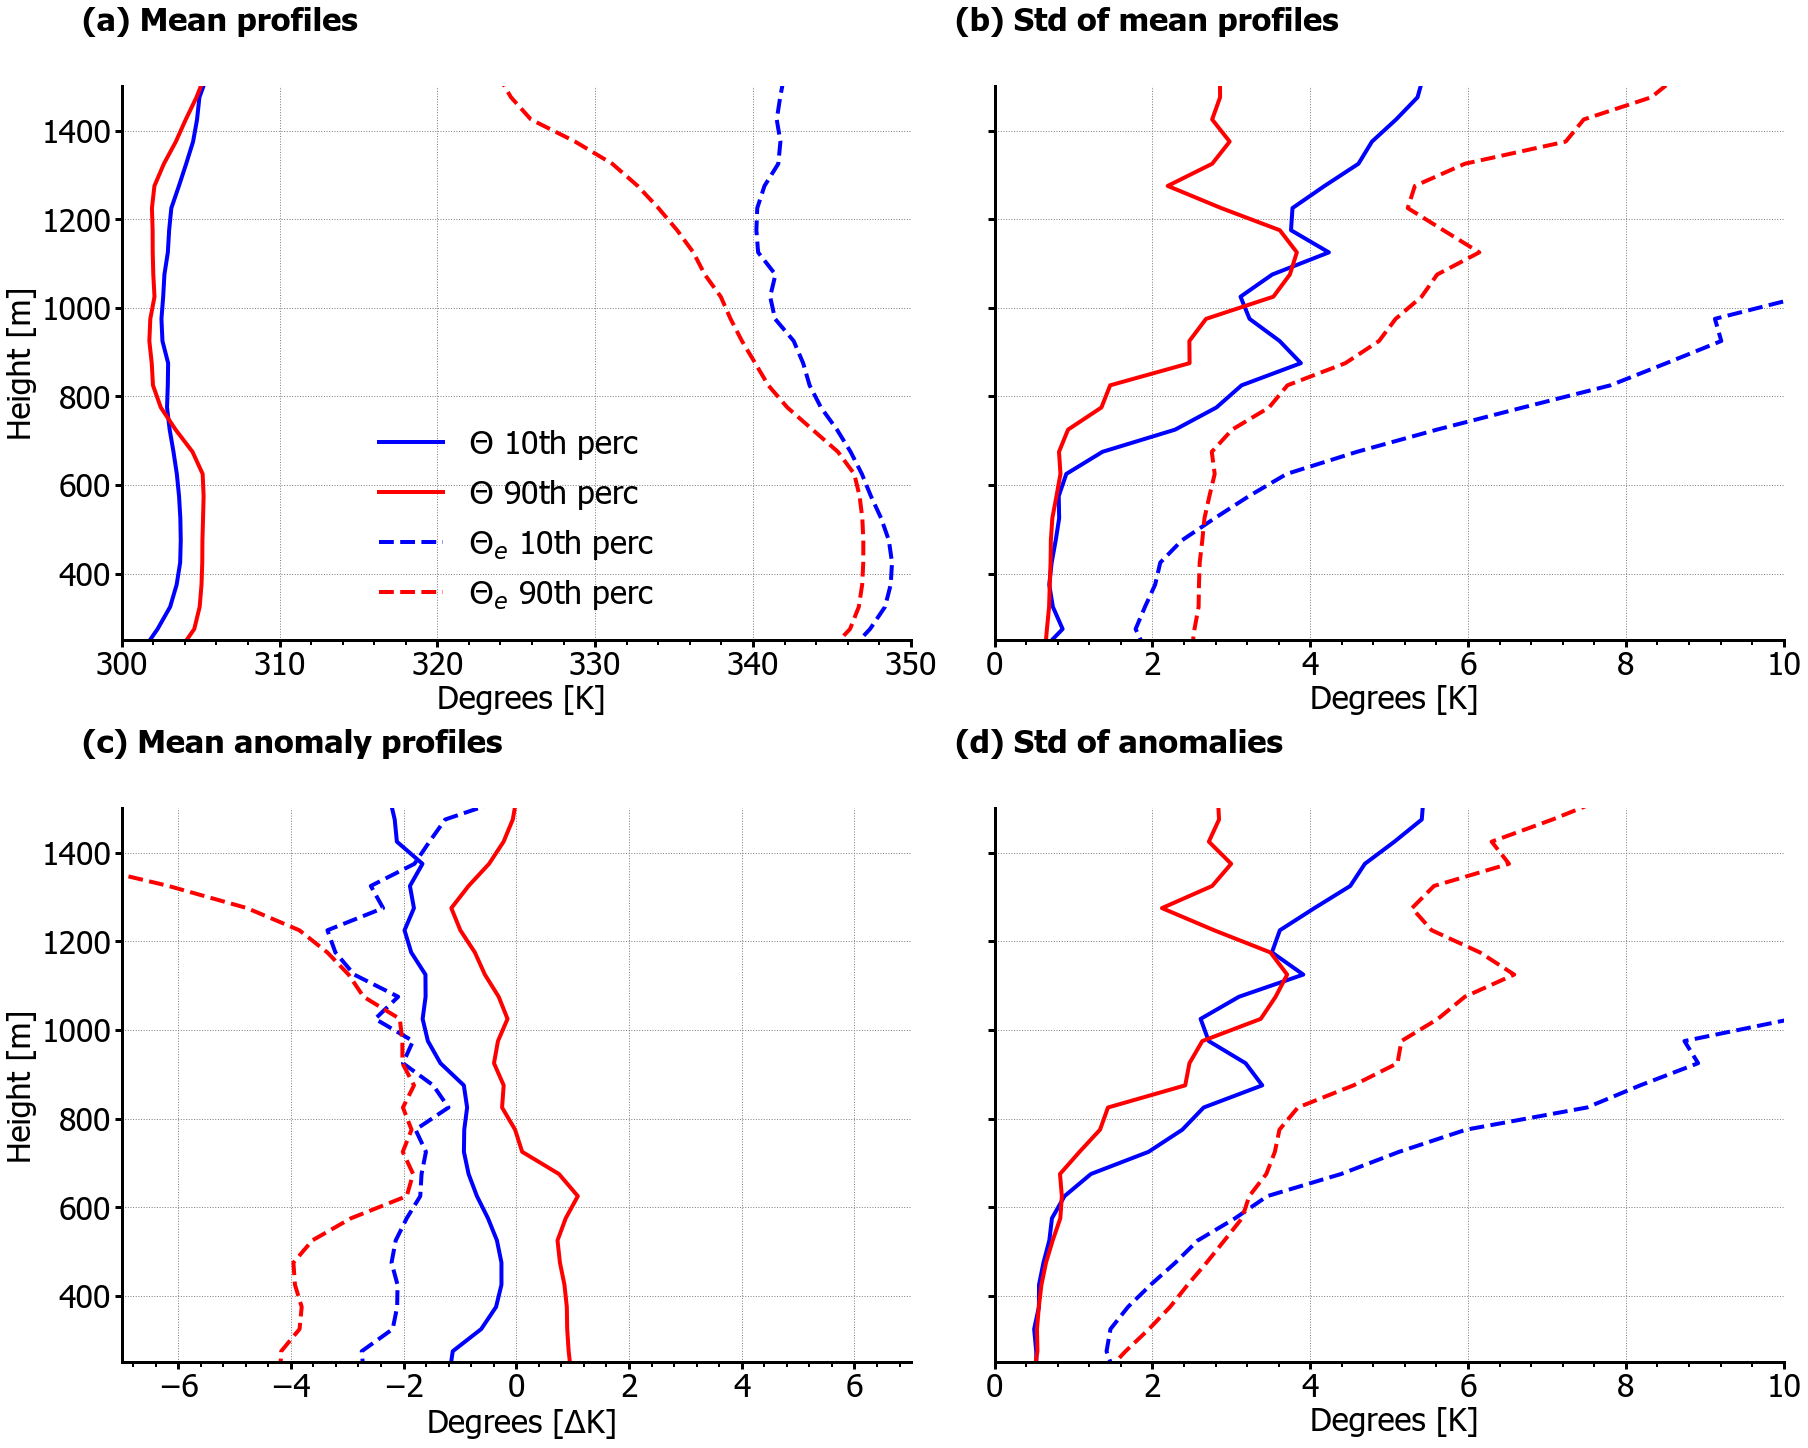

In [79]:
# composite figure variables 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'



dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :15,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']


fig, axs = plt.subplots(2, 2, figsize=(25,20), sharey=True, constrained_layout=True)# 

#axs[0,0].set_xlabel("Horizontal wind speed [ms$^{-1}$]", fontsize=fontSizeX)
axs[0,0].set_ylabel("Height [m]", fontsize=fontSizeY)
axs[0,0].plot(mean_profile_10.theta.values, theta_e_dataset['height'].values, label='$\Theta$ 10th perc', color='blue', linewidth=4)
axs[0,0].plot(mean_profile_90.theta.values, theta_e_dataset['height'].values, label='$\Theta$ 90th perc', color='red', linewidth=4)
axs[0,0].plot(mean_profile_10.theta_e.values, theta_e_dataset['height'].values, label='$\Theta_e$ 10th perc', color='blue', linestyle='--', linewidth=4)
axs[0,0].plot(mean_profile_90.theta_e.values, theta_e_dataset['height'].values, label='$\Theta_e$ 90th perc', color='red', linestyle='--', linewidth=4)
axs[0,1].plot(std_profile_10.theta.values, theta_e_dataset['height'].values, label='10th perc', color='blue', linewidth=4)
axs[0,1].plot(std_profile_90.theta.values, theta_e_dataset['height'].values, label='90th perc', color='red', linewidth=4)
axs[0,1].plot(std_profile_10.theta_e.values, theta_e_dataset['height'].values, label='10th perc', color='blue', linestyle='--', linewidth=4)
axs[0,1].plot(std_profile_90.theta_e.values, theta_e_dataset['height'].values, label='90th perc', color='red', linestyle='--', linewidth=4)
axs[0,0].legend(frameon=False)
axs[0,0].grid(color='grey', linestyle='dotted',  linewidth=1)
axs[0,1].grid(color='grey', linestyle='dotted',  linewidth=1)
axs[1,0].grid(color='grey', linestyle='dotted',  linewidth=1)
axs[1,1].grid(color='grey', linestyle='dotted',  linewidth=1)

axs[1,0].plot(mean_profile_10.theta_anomaly.values, theta_e_dataset['height'].values, label='10th perc', color='blue', linewidth=4)
axs[1,0].plot(mean_profile_90.theta_anomaly.values, theta_e_dataset['height'].values, label='90th perc', color='red', linewidth=4)
axs[1,0].plot(mean_profile_10.theta_e_anomaly.values, theta_e_dataset['height'].values, label='10th perc', color='blue', linestyle='--', linewidth=4)
axs[1,0].plot(mean_profile_90.theta_e_anomaly.values, theta_e_dataset['height'].values, label='90th perc', color='red', linestyle='--', linewidth=4)
axs[1,1].plot(std_profile_10.theta_anomaly.values, theta_e_dataset['height'].values, label='10th perc', color='blue', linewidth=4)
axs[1,1].plot(std_profile_90.theta_anomaly.values, theta_e_dataset['height'].values, label='90th perc', color='red', linewidth=4)
axs[1,1].plot(std_profile_10.theta_e_anomaly.values, theta_e_dataset['height'].values, label='10th perc', color='blue', linestyle='--', linewidth=4)
axs[1,1].plot(std_profile_90.theta_e_anomaly.values, theta_e_dataset['height'].values, label='90th perc', color='red', linestyle='--', linewidth=4)

axs[0,0].set_ylim(250., 1500.)
axs[0,0].set_xlabel(' Degrees [K]')
axs[0,0].set_xlim(300., 350.)
axs[1,0].set_ylim(250., 1500.)
axs[1,0].set_xlim((-7., 7.))
axs[0,1].set_xlim(0., 10.)
axs[1,1].set_xlim(0., 10.)
axs[1,0].set_xlabel(' Degrees [$\Delta$K]')
axs[1,1].set_xlabel(' Degrees [K]')
axs[0,1].set_xlabel(' Degrees [K]')
axs[0,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1,0].set_ylabel('Height [m]', fontsize=fontSizeX)

for ax, l in zip(axs[:].flatten(), ['(a) Mean profiles',  '(b) Std of mean profiles ', '(c) Mean anomaly profiles', '(d) Std of anomalies']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)
    #ax.set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)
    
fig.savefig(path_out_plots+'figure_theta_percentile_profiles.png', format='png')

(290.0, 310.0)

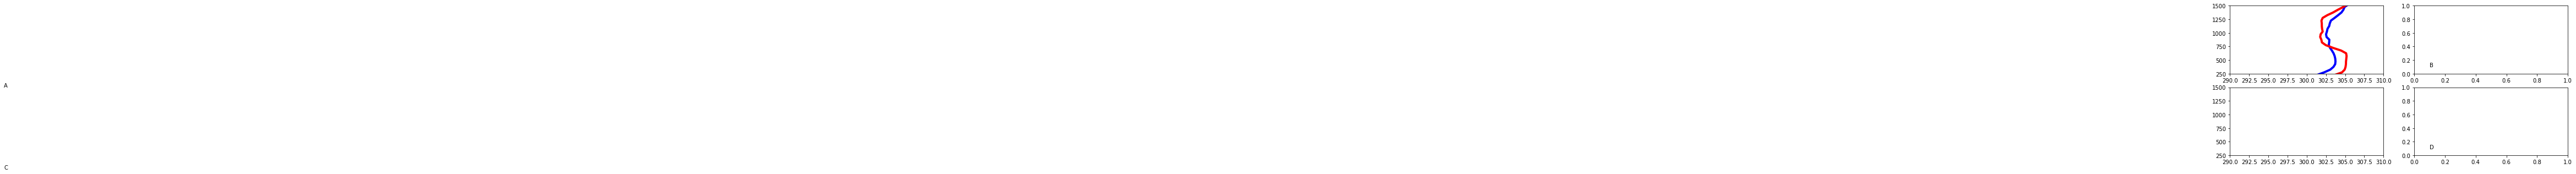

In [55]:
figure_mosaic = """
AB
CD"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(11,5))

for label, ax in axes.items():
    ax.text(0.1,0.1,label)

axes['A'].plot(mean_profile_10.theta.values, theta_e_dataset['height'].values, label='10th perc', color='blue', linewidth=4)
axes['A'].plot(mean_profile_90.theta.values, theta_e_dataset['height'].values, label='90th perc', color='red', linewidth=4)
axes['C'].plot(mean_profile_10.theta_e.values, theta_e_dataset['height'].values, label='10th perc', color='blue', linestyle='--', linewidth=4)
axes['C'].plot(mean_profile_90.theta_e.values, theta_e_dataset['height'].values, label='90th perc', color='red', linestyle='--', linewidth=4)
axes['A'].set_ylim(250., 1500.)
axes['A'].set_xlim(290., 310.)
axes['C'].set_ylim(250., 1500.)
axes['C'].set_xlim(290., 310.)




In [62]:
mean_profile_10

<xarray.Dataset>
Dimensions:          (height: 57)
Coordinates:
  * height           (height) float64 225.0 275.0 325.0 ... 2.975e+03 3.025e+03
Data variables:
    theta            (height) float64 301.3 302.3 303.1 303.5 ... 320.4 nan nan
    theta_e          (height) float64 346.1 347.4 348.4 348.7 ... 328.7 nan nan
    theta_anomaly    (height) float64 -1.185 -1.127 -0.6221 ... 0.3198 nan nan
    theta_e_anomaly  (height) float64 -2.707 -2.741 -2.193 ... -0.2058 nan nan
    SST              float64 26.38